<a href="https://colab.research.google.com/github/hooked-on-mas/AutoGenBook/blob/main/AutoGenBookJP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 仕様の策定

以下を入力した後，【すべてのセルを実行（Ctrl + F9）】を押してください．  

In [2]:
# @markdown ## 必須項目
# @markdown ### 教科書の内容
book_content = "殺人、推理小説" #@param {type:"string"}
# @markdown ### 大まかなページ数
n_pages = 15 # @param {"type":"integer","placeholder":"40"}
# @markdown ### 出力形式
tex_output = True #@param {type:"boolean"}
pdf_output = True #@param {type:"boolean"}
md_output = True #@param {type:"boolean"}

# @markdown ## 任意項目
# @markdown ### 想定する読者層
target_readers = "東野圭吾風の作成が好きな人" #@param {type:"string"}
# @markdown ### 数式の出現度合い
equation_frequency_level = 1 #@param {type:"slider", min:1, max:5, step:1}
# @markdown ### その他、内容についての要望
additional_requirements = "" #@param {type:"string"}

if book_content == "":
    print('\033[31m'+'教科書の内容を指定してください。'+'\033[0m')
if n_pages == 0:
    print('\033[31m'+'ページ数を指定してください．'+'\033[0m')

## プロンプトの定義

In [3]:
# 共通のプロンプト
prompt_common = f"""
以下の内容で本を執筆します．
{book_content}
本全体のページ数は{n_pages}ページ，1ページあたり40行を想定しています．ですます調で記述してください．
"""
if target_readers != "":
    prompt_common += f"想定読者としては以下を考えています．\n {target_readers}"
if additional_requirements != "":
    prompt_common += f"また，以下を考慮に入れてください．\n {additional_requirements}"

# 本・章のタイトルと概要の生成用プロンプト
prompt_book_title = prompt_common + """
以上をもとに，以下のようなjson形式で，本・章のタイトル，本・章の概要を示してください．
本の概要には，内容の要約だけではなく，本の主な目的やカバーする内容の範囲と深さなどについても触れてください．5から10文ほどで，詳細にお願いします．
また，各章に割くべきページ数を考えてください．ページ数は0.1単位で，0.8ページのように書いてください．
それに加え，内容の意味的凝集性から考えて，各章を分節化する必要がありますかどうか（needsSubdivision）を考えてください．trueかfalseで答えてください．
推測や未確認の情報は含めないでください．また，タイトルに第何章であるかは書かないでください．
節の数は必要に応じて変えてください．
```json
{{"title": "",
"summary": "",
"childs":
    [{{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }},
    {{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }},
    {{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }}]
}}
```
"""

# 分節化用プロンプト
prompt_section_list_creation = prompt_common + """
以上の情報から，{book_title}というタイトルで本を作成しようと思います．本の概要を以下に示します．
{book_summary}
その中の{target}についての部分を{n_pages}ページで作成したいです．1ページあたり40行を想定しています．
この部分の概要は，以下です．
{section_summary}
この部分を分節化して，複数のパートに分けて欲しいです．
各パートのタイトルと概要を以下のようなjson形式にて出力してください．また，各パートに割くべきページ数を考えてください．ページ数は0.1単位で，0.8ページのように書いてください．
それに加え，内容の意味的凝集性から考えて，各章を分節化する必要がありますかどうか（needsSubdivision）を考えてください．trueかfalseで答えてください．
タイトルに第何章・節であるかは書かないでください．
```json
[{{"title": "",
"summary": "",
"n_pages": ,
"needsSubdivision":
}},
{{"title": "",
"summary": "",
"n_pages": ,
"needsSubdivision":
}}]
```
"""

# 本文の内容の生成用プロンプト
prompt_content_creation = prompt_common + """
以上の情報から，{book_title}というタイトルで本を作成しようと思います．本の概要を以下に示します．
{book_summary}
その中の{target}についての部分を{n_pages}ページで作成したいです．1ページあたり40行を想定しています．
この部分の概要は，以下です．
{section_summary}
その部分の内容を{n_pages}分，つまり{n_pages} × 40行分をLaTeXで出力してください．プリアンブルで必要なライブラリはすべてインポートされています．
推測や未確認の情報は含めないでください．見出しは必要なく，本文のみを出力してください．
{equation_frequency}
数式をネストしないように，すなわち\[ \begin{{align*}} \end{{align*}} \]ではなく，\begin{{align*}} \end{{align*}}とするよう気をつけてください．
出力形式は以下のようにお願いします．
```tex
本文の内容
```
"""

## パラメータ設定

In [4]:
# パラメータ
max_depth = 5 # 1なら節のみ，2なら小節まで．．．
max_output_pages = 1.5 # LLMの最大出力ページ数

book_node_name = "book" # ルートノードの名前

openai_api_secret_key_name = 'openai_api' # openai_apiをシークレットキーとして登録した時の変数名
model_name = "gpt-4o" # モデルの名前

## ライブラリのインストール・インポート

In [5]:
!apt-get update
!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
!apt-get install -y latexmk
!apt-get install -y texlive-lang-japanese
!apt-get install -y texlive-latex-extra
!apt-get install -y texlive-science
%pip install langchain
%pip install -qU langchain-openai
%pip install pygraphviz
%pip install pylatex

%pip install langchain-community
%pip install langchain-core
%pip install python-dotenv
%pip install requests
%pip install openai

import time,os

import os
import re
import json
import networkx as nx
from google.colab import userdata
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

from google.colab import files

from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,032 kB]
G

## グラフの作成

In [6]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

## タイトル・各章の作成

### 関数の定義

In [7]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Markdown形式のテキストから最初に見つかったJSONデータを抽出し、Pythonの辞書型に変換して返す関数。

    Args:
        markdown_text (str): Markdown形式の文字列。この文字列の中にJSON形式のデータが含まれていると想定される。

    Returns:
        dict or None: 正しい形式のJSONが見つかれば辞書型で返し、見つからなかった場合やパースに失敗した場合はNoneを返す。
    """

    # MarkdownからJSONの開始点を見つける
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # 文字列全体をトラバースし、ネストされた括弧のバランスをチェックする
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # ブレースのバランスが取れたらその時点で抜き出す
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
              # JSON形式に変換
              json_data = json.loads(json_string)
              return json_data
            except json.JSONDecodeError as e:
                print(f"JSONのパースエラー: {e}")
                return None
            return

    # 閉じ括弧が見つからない場合
    return None

### LLMによる出力

In [8]:
class ChatOpenRouter(ChatOpenAI):
    openai_api_base: str
    openai_api_key: str
    model_name: str

    def __init__(
        self,
        model_name: str,
        openai_api_key: Optional[str] = None,
        openai_api_base: str = "https://openrouter.ai/api/v1",
        **kwargs
    ):
        openai_api_key = openai_api_key or os.getenv("OPENROUTER_OPENAI_API_KEY")
        super().__init__(
            openai_api_base=openai_api_base,
            openai_api_key=openai_api_key,
            model_name=model_name,
            **kwargs
        )

In [9]:
openai_api_key = userdata.get("API_KEY")
model_name = "qwen/qwen-2.5-7b-instruct"
llm = ChatOpenRouter(
    openai_api_key=openai_api_key,
    model_name=model_name
)

prompt = ChatPromptTemplate.from_template(prompt_book_title)
chain = prompt | llm
result = chain.invoke({
    "book_content": book_content,
    "target_readers": target_readers,
    "n_pages": n_pages,
    "additional_requirements": additional_requirements
})

book_json = extract_book_and_chapter_contents(result.content)
if  book_json == None:
  print("book_jsonの作成に失敗しました。")
  print("result.contentのタイプは",type(result.content),"長さは",len(result.content))
  print("book_jsonのタイプは",book_json,)
  print("恐らくllm_modelのコンテキストlength不足または有料モデルを使用しています。あなたの使用したmodelは",model_name)
else:
  print("合格")

合格


### 結果を本グラフへ格納

In [10]:
# 本について
book_graph.add_nodes_from([(
    book_node_name,
    {"title": book_json["title"],
    "summary": book_json["summary"],
    "n_pages": n_pages,
    "needsSubdivision": True}
)])

# 章（部）について
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## タイトルと構成の確認

### タイトルと構成の表示

In [11]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## タイトル：" + book_node["title"] + "（ページ数：" + str(book_node["n_pages"]) + "）"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### 第" + str(idx+1) + "章：" + child_node["title"] + "（ページ数：" + str(child_node["n_pages"]) + "）"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)


 ## タイトル：真実への一歩（ページ数：15）
 この短編推理小説は、東野圭吾風の緊張感と複雑なミステリー構造を体験できるように設計されています。主人公は、複数の証拠と混乱する事件の手がかりから、自分が知らなかった家族の秘密に迫ります。読者は、複雑な展開や不意打ちの展開に引き込まれ、最後の真相を解き明かす瞬間まで目を離せなくなります。
 ### 第1章：第一章：謎の始まり（ページ数：1.5）
事件は、主人公の家に突然訪れた謎の訪問客から始まります。その人物の言動は疑問を抱かせる一方で、主人公は事件の中心に身を置くことに気づきます。この章では、事件の舞台と主要な登場人物を紹介し、その雰囲気と緊張感を醸し出します。
 ### 第2章：第二章：証拠の収集（ページ数：2.3）
主人公は事件の証拠を探し始めるが、その過程でさまざまな謎が浮かび上がり、家族の秘密が明らかになる。この章では、主人公の行動と思考の過程を通じて、事件の複雑さが徐々に明らかになる様子を描きます。
 ### 第3章：第三章：真相への接近（ページ数：2.2）
様々な証拠と情報を元に、主人公は事件の真相に近づきます。しかし、新たな証拠の出現により、これまでの推測が崩れ、新たな疑問が生じる。この章では、主人公の推理と推理の結果が詳細に描かれ、読者も真相に近づいていくことを実感させます。
 ### 第4章：第四章：最後の真相（ページ数：1.8）
主人公は最終的に真相を解き明かし、家族の過去の秘密を明らかにします。この章では、証拠と推理が最後の真相に繋がるまでの過程が詳細に描かれ、読者も一緒にその瞬間を共にします。
 ### 第5章：第五章：遺産（ページ数：1.4）
最後の真相が明らかとなった後、主人公は事件の影響で得た知識と経験を新たな冒険に活かす決意をする。この章では、主人公の成長と新たな始まりの予感が描かれ、物語は閉じることなく新たな展開を示します。

## 本グラフの作成

### 関数の定義

In [12]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSONデータが見つかりませんでした。")
        return None

def extract_section_content(markdown_text):

    pattern = r'```tex\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        tex_string = match.group(1)
        return tex_string
    else:
        print("TeXデータが見つかりませんでした。")
        return None

def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "数式はほぼ使用せず、すべての概念を平易な言葉で説明してください。数式が絶対に必要な場合のみ、最小限の使用に留めてください。"
    elif equation_frequency_level == 2:
        return "数式は控えめに使用し、主に文章で説明を行ってください。必要な場合のみ簡単な数式を用いてください。"
    elif equation_frequency_level == 3:
        return "数式と文章による説明をバランス良く組み合わせてください。重要な概念は数式で表現し、それ以外は文章で補足してください。"
    elif equation_frequency_level == 4:
        return "数式を積極的に活用し、概念や関係性を正確に表現してください。ただし、重要な説明は文章でも補足してください。"
    elif equation_frequency_level == 5:
        return "数式を最大限に活用してください。可能な限り多くの概念や関係性を数式で表現してください．"

### LLMによる出力とグラフへ結果の格納

In [13]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]


            if (child_node["needsSubdivision"] or child_node["n_pages"] >= max_output_pages) and depth < max_depth-1:

                # LLMによる出力
                prompt = ChatPromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # 出力を辞書型に変換
                section_json = extract_section_list(result.content)

                # グラフノードの作成・結果の格納
                book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                # 分節化した場合のみ次の親になる
                next_parent_list.append(child_node_name)

            elif not child_node["needsSubdivision"] or depth == max_depth-1:

                # LLMによる出力
                prompt = PromptTemplate.from_template(prompt_content_creation)
                chain = prompt | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # 出力をファイルに保存
                contents_tex = extract_section_content(result.content)
                with open(child_node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
                    f.write(contents_tex)

                # グラフノードの作成・結果の格納
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

## 本グラフの表示

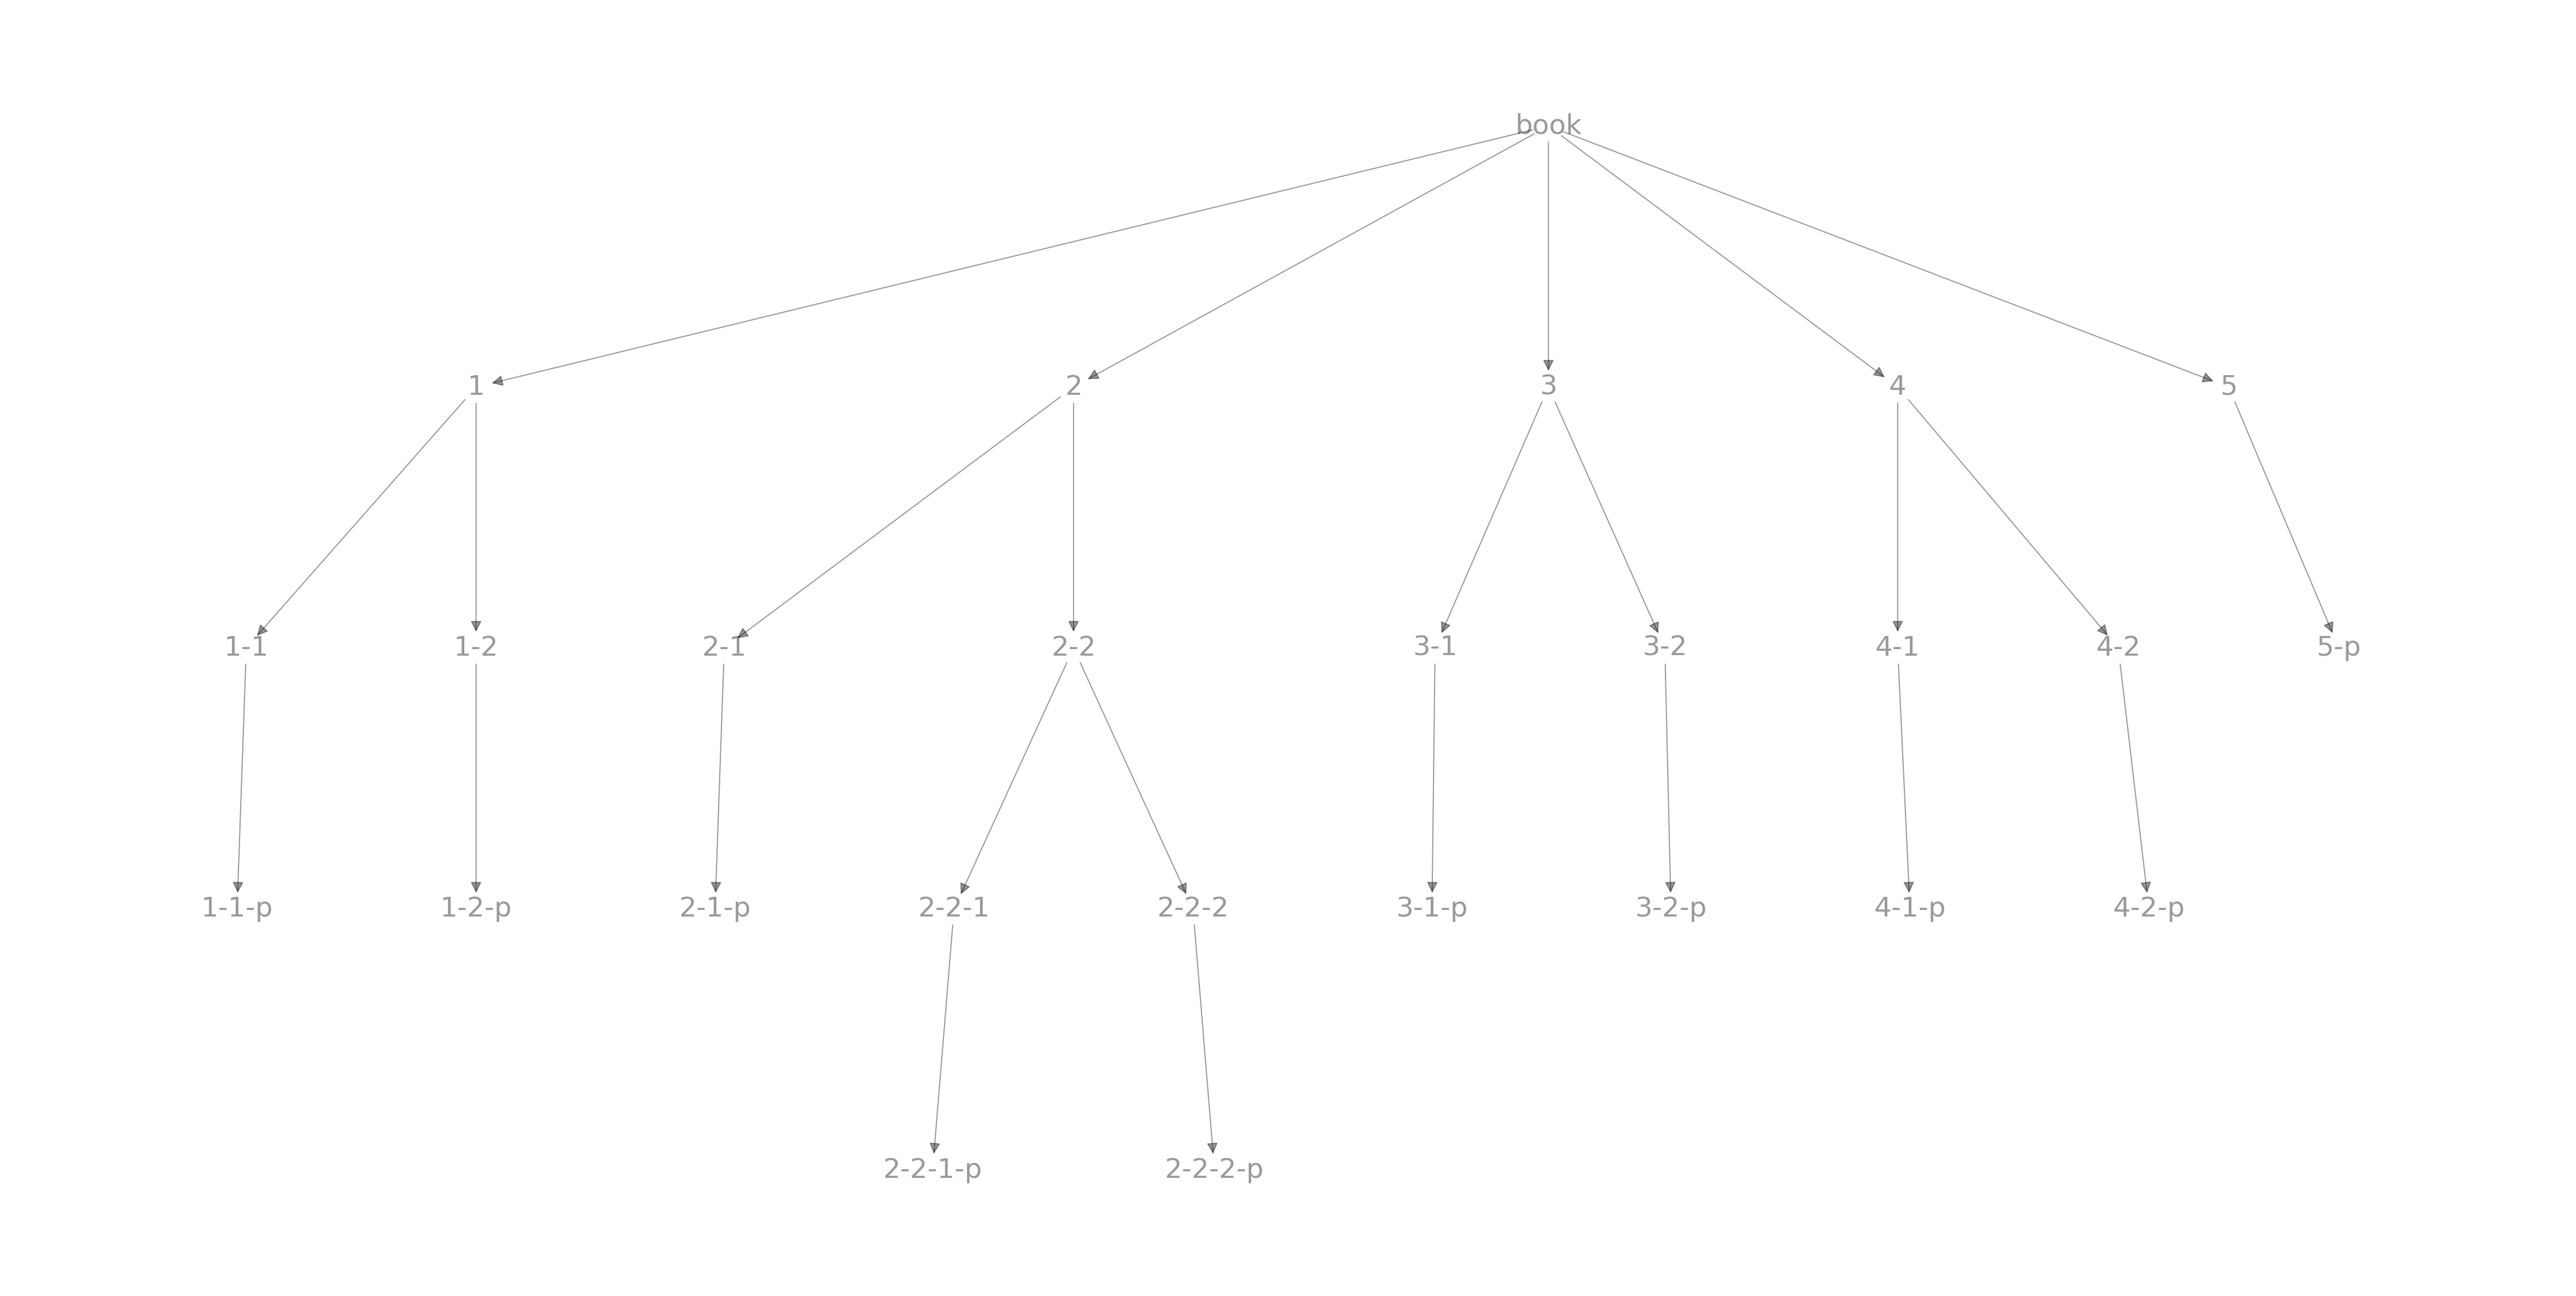

In [14]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=100,
        node_color='w',
        alpha=0.4,
        node_shape='s',
        width=0.5)

## 本の作成

### latexmkrcファイルの作成

In [15]:
# ホームディレクトリのパスを取得
home_dir = os.path.expanduser("~")

# .latexmkrcファイルのパスを作成
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# latexmkrcファイルの中身
content = '''$latex = 'platex -synctex=1 -halt-on-error -interaction=nonstopmode -file-line-error %O %S';
$bibtex = 'pbibtex %O %S';
$biber = 'biber --bblencoding=utf8 -u -U --output_safechars %O %S';
$makeindex = 'mendex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 3;'''

# ファイルを作成して内容を書き込む
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc file has been created successfully at {latexmkrc_path}")
except IOError as e:
    print(f"An error occurred while creating the file: {e}")

.latexmkrc file has been created successfully at /root/.latexmkrc


### LaTeXで本文の作成

### 関数の定義

In [16]:
def extract_content_list(string_list):
    # この関数は、入力されたstring_listから特定のパターン（数字とハイフンの組み合わせで'-p'で終わる）
    # にマッチする文字列のみを抽出し、新しいリストとして返す
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    # この関数は、文字列sを数字の部分で分割し、それらを整数のリストに変換する
    # これにより、数値的な順序でソートするためのカスタムキーを生成する
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    # この関数は、入力されたstring_listを、custom_sort_key関数で定義された
    # カスタムキーを使用してソートし、ソートされた新しいリストを返す
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

### LaTeXドキュメントの作成

In [17]:
# pylatexにより、PDFを作成
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="jsreport", geometry_options=geometry_options)

# プリアンブル・タイトルの追加
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("date", NoEscape(r"\today")))
doc.append(NoEscape(r"\maketitle"))
doc.append(NoEscape(r"\tableofcontents"))

In [18]:
# 本文の内容を持つノードを順番に並び替え
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# 本文の追加
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # 章の見出しの追加
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 節の見出しの追加
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 小節の見出しの追加
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 本文の追加
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    with open(tex_file_path, "r", encoding='UTF-8') as file:
        tex_content = file.read()
        doc.append(NoEscape(tex_content))

In [19]:
import re

def test_document_structure(doc):
    print("ドキュメント構造テスト開始")

    # エンコーディングチェック
    try:
        content = doc.dumps()
        content.encode('utf-8')
        print("エンコーディングチェック: OK (UTF-8)")
    except UnicodeEncodeError:
        print("エンコーディングチェック: エラー (UTF-8ではありません)")

    # 日本語文字のチェック
    if re.search(r'[ぁ-んァ-ン一-龥]', content):
        print("日本語文字チェック: OK")
    else:
        print("日本語文字チェック: 警告 (日本語文字が見つかりません)")

    # ドキュメントクラスのチェック
    if "\\documentclass" in content:
        print("ドキュメントクラスチェック: OK")
    else:
        print("ドキュメントクラスチェック: エラー (\\documentclassが見つかりません)")

    # タイトルと目次のチェック
    if "\\maketitle" in content and "\\tableofcontents" in content:
        print("タイトルと目次チェック: OK")
    else:
        print("タイトルと目次チェック: 警告 (\\maketitleまたは\\tableofcontentsが見つかりません)")

    print("ドキュメント構造テスト終了")

def check_type(doc):
  import sys

  # docの内容をダンプ
  latex_source = doc.dumps()

  # エンコーディングの検出
  try:
      encoding = sys.getdefaultencoding()
      latex_source.encode(encoding)
      print(f"ドキュメントは {encoding} でエンコードされています。")
  except UnicodeEncodeError:
      print("ドキュメントはUTF-8でエンコードされています。")

  # 総文字数
  total_chars = len(latex_source)
  print(f"総文字数: {total_chars}")


  # 総バイト数
  if encoding == "utf-8":
    print(f"総バイト数: {total_chars*3}")

  # ASCII文字とnon-ASCII文字の数をカウント
  ascii_chars = sum(1 for c in latex_source if ord(c) < 128)
  non_ascii_chars = total_chars - ascii_chars
  print(f"ASCII文字数: {ascii_chars}")
  print(f"非ASCII文字数: {non_ascii_chars}")

  # BOMの確認
  if latex_source.startswith('\ufeff'):
      print("BOM (Byte Order Mark) が検出されました。")
  else:
      print("BOMは検出されませんでした。")

  # LaTeXの入力エンコーディング設定を確認
  if r'\usepackage[utf8]{inputenc}' in latex_source:
      print("LaTeXはUTF-8入力を使用するように設定されています。")
  elif r'\usepackage[latin1]{inputenc}' in latex_source:
      print("LaTeXはLatin-1 (ISO-8859-1) 入力を使用するように設定されています。")
  else:
      print("LaTeXの入力エンコーディング設定が見つかりません。")

# テストの実行　信用しないで
print(type(doc))
test_document_structure(doc)
print()
check_type(doc)

<class 'pylatex.document.Document'>
ドキュメント構造テスト開始
エンコーディングチェック: OK (UTF-8)
日本語文字チェック: OK
ドキュメントクラスチェック: OK
タイトルと目次チェック: OK
ドキュメント構造テスト終了

ドキュメントは utf-8 でエンコードされています。
総文字数: 4832
総バイト数: 14496
ASCII文字数: 729
非ASCII文字数: 4103
BOMは検出されませんでした。
LaTeXはUTF-8入力を使用するように設定されています。


### PDF生成

In [20]:
import subprocess
!rm -rf /content/*
!ls /content
doc.generate_tex(filepath="doc")
!ls /content

print()
doc.generate_pdf(
    book_node["title"],
    clean_tex=False,
    silent=False
) # コンパイルエラーによりUnicodeDecodeErrorが出る
!ls /content

doc.tex



UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 9550-9551: invalid continuation byte

In [ ]:
# ダウンロード
if tex_output:
    files.download("/content/" + book_node["title"] + ".tex")

if pdf_output:
    files.download("/content/" + book_node["title"] + ".pdf")

if md_output:
    %pip install latex2markdown
    import latex2markdown

    with open("/content/" + book_node["title"] + ".tex", "r") as f:
        latex_string = f.read()

    l2m = latex2markdown.LaTeX2Markdown(latex_string)

    markdown_string = l2m.to_markdown()

    with open("/content/" + book_node["title"] + ".md", "w") as f:
        f.write(markdown_string)
    files.download("/content/" + book_node["title"] + ".md")